In [85]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import wave
import pylab
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pydub import AudioSegment
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras import layers, models, Model
import tensorflow as tf
from pydub import AudioSegment
from tensorflow.keras import Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from audiomentations import Compose, TimeMask, SpecFrequencyMask, PitchShift, AddGaussianNoise
from sklearn.model_selection import train_test_split
from scipy.ndimage import zoom

Next iteration of model:
  Going back to melspectrograms
  sr=None
  avoiding resizing spectrogram
  

  to look into later
  minmax scaler - used in VGG?

## SPLIT AUDIO

In [ ]:
#IF STARTING FROM SCRATCH, CREATE THESE FOLDERS. MAKE SURE THE FULL PODCAST FILES YOU NEED ARE IN FULL_PODCAST
full_audio_directory = '../raw_data/full_podcast' # full audio can be found here
episode_directory = '../raw_data/5_sec_clips/99percentinvisible/' # where new clips will be stored
input_podcast_name = 'infernal_machine'
output_podcast_name = 'planet_money'
wav_clips_directory = '../raw_data/5_sec_clips/99percentinvisible/infernal_machine'
images_directory = '../raw_data/5_sec_clips/99percentinvisible/infernal_machine_images'

In [3]:
def split_files(original_file, ad_list, podcast_name, episode_directory, run_env="local"):

    """
    This function takes an original audio file name, list of integers showing
    when each ad starts and ends and a podcast name and splits up the original
    file into 5 second chunks, naming each one according to whether it contains
    ads or not.
    """

    # Create a folder for the podcast and their clips:
    podcast_folder = os.path.join(episode_directory, podcast_name)

    if run_env == "local":
        #Check if the folder already exists and has any .mp3 files
        if os.path.exists(podcast_folder) and any(fname.endswith('.wav') for fname in os.listdir(podcast_folder)):
            print(f"Skipping {podcast_name} because it has already been processed.")
            return 'skipped'

        # Create the directory if doesnt exist:
        if not os.path.exists(podcast_name):
            os.makedirs(podcast_folder)
            print(f"Created folder: {podcast_folder}")


    # Determine the file extension and load the audio file accordingly
    file_extension = os.path.splitext(original_file)[1].lower()

    if file_extension == '.mp3':
        new_audio = AudioSegment.from_mp3(original_file)
    elif file_extension == '.wav':
        new_audio = AudioSegment.from_wav(original_file)
    else:
        raise ValueError(f"Unsupported file format: {file_extension}. Only .mp3 and .wav are supported.")

    # Save duration
    duration = int(new_audio.duration_seconds)

    # Set default to no_ad
    is_ad = '0'

    # If the ad_list doesn't start with 0, then the ads don't start straight away.
    # in this case, insert '0' first in the list so that a segment is created at the start.
    if ad_list[0] != 0:
        ad_list.insert(0, 0)
        is_ad = '1'

    # Add duration at the end so that the end segments can be made.
    if ad_list[-1] != duration:
        ad_list.append(duration)

    #Go through each segement in the list, label whether the section is an ad or not
    for index in range(0,len(ad_list)-1):
        start = ad_list[index]
        end = ad_list[index+1]
        # Toggle between 'ad' and 'no_ad'
        if is_ad == '1':
            is_ad = '0'
        else:
            is_ad = '1'

        # Go through each second in the segment and create a new 5 second clip from here.
        # Stop before the end of the segment so that only 5 second clips are created
        for tc in range(start, (end-4)):
            start_clip = tc*1000 #pydub works with milliseconds, so seconds are converted here
            end_clip = (tc+5)*1000

            # Construct the file path for saving
            output_file = os.path.join(podcast_folder, f'{is_ad}_{tc}_{duration}_{podcast_name}.wav')

            if run_env == "local":
                # Save clip locally:
                new_audio[start_clip:end_clip].export(output_file, format='wav')
                print(f"Saved clip: {output_file}")


    is_ad = '0'
    return 'finished'

In [ ]:
podcast_files_mp3_wav = [
    (os.path.join(base_directory, "infernal_machine.mp3"), [0,50, ((15*60)+50), ((16*60)+21),((30*60)+18), ((30*60)+49)], "infernal_machine"),
    (os.path.join(base_directory, "world_out.mp3"), [0,30, ((14*60)+16), ((14*60)+48), ((34*60)+36), ((35*60)+8)], "world_out"),
    (os.path.join(base_directory, "medellin_revisited.mp3"), [0,30, ((14*60)+16), ((14*60)+48), ((34*60)+36), ((35*60)+8)], "medellin_revisited"),
    (os.path.join(base_directory, "planetmoney.mp3"), [0,30, ((22*60)+13), ((22*60)+44)], "planetmoney"),
    (os.path.join(base_directory, "christiania.mp3"), [((18*60)+29), ((19*60)+20)], "christiania"),
    (os.path.join(base_directory, "not_built_for_this_6.mp3"), [0, 30, ((16*60)+8), ((16*60)+59)], "not_built_for_this_6"),
    (os.path.join(base_directory, "not_built_for_this_4.mp3"), [0, 30, ((22*60)+21), ((23*60)+15), ((49*60)+41), ((50*60)+12)], "not_built_for_this_4"),
    (os.path.join(base_directory, "not_built_for_this_3.mp3"), [((16*60)+16), ((17*60)+9)], "not_built_for_this_3"),
    (os.path.join(base_directory, "not_built_for_this_2.mp3"), [((22*60)+28), ((23*60)+20)], "not_built_for_this_2"),
    (os.path.join(base_directory, "not_built_for_this_2.mp3"), [((22*60)+28), ((23*60)+20)], "not_built_for_this_2"),
    (os.path.join(base_directory, "outrageous_fortune.mp3"), [((21*60)+59), ((22*60)+52)], "outrageous_fortune"),
    (os.path.join(base_directory, "olympics.mp3"), [0, 30, ((22*60)+28), ((23*60)+21)], "olympics")
]

# Loop through each file and split into 5 sec chunks
for file_name, ad_list, podcast_name in podcast_files_mp3_wav:
    result = split_files(file_name, ad_list, podcast_name, episode_directory)
    print(f'Processing {podcast_name}: {result}')

Created folder: ../raw_data/5_sec_clips/99percentinvisible/infernal_machine
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/infernal_machine/1_0_1848_infernal_machine.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/infernal_machine/1_1_1848_infernal_machine.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/infernal_machine/1_2_1848_infernal_machine.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/infernal_machine/1_3_1848_infernal_machine.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/infernal_machine/1_4_1848_infernal_machine.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/infernal_machine/1_5_1848_infernal_machine.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/infernal_machine/1_6_1848_infernal_machine.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/infernal_machine/1_7_1848_infernal_machine.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/infernal_machine/1_8_1848_infernal_machine.wav
Saved 

# DATA PREPARATION:

In [ ]:
#------------------Function to create spectrogram from audio file------------------
def create_spectrogram(wav_path, sr=None):

    y, sr = librosa.load(wav_path)
    # Create mel spectrogram
    mel_spect = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=128,  # Number of mel bands
        fmax=8000    # Maximum frequency
    )
    # Convert to log scale and return
    return np.array(librosa.power_to_db(mel_spect, ref=np.max))

#------------------Function to create spectrogram from audio file------------------
#TRY WITHOUT
def resize_spectrogram(spectrogram, output_size):
    sp_row, sp_col = spectrogram.shape
    out_row, out_col = output_size
    resized_spec = zoom(spectrogram, (out_row/sp_row, out_col/sp_col))
    return resized_spec

#------------------Function to resize spectrogram------------------
#IGNORE
def minmax_scaler(spectrogram):
    min_val = np.min(spectrogram)
    max_val = np.max(spectrogram)

    normalised_spectrogram = (spectrogram - min_val) / (max_val - min_val)

    return normalised_spectrogram
#------------------Function to normalise spectrogram------------------
#IGNORE
def reshape_spectrogram(spectrogram):
    temp_spectogrram =  np.stack((spectrogram, spectrogram, spectrogram), axis=2)
    return temp_spectogrram

In [ ]:
# IMAGE_HEIGHT = 224
# IMAGE_WIDTH = 224
# BATCH_SIZE = 57
# N_CHANNELS = 3
# N_CLASSES = 1

In [8]:
# Function to loop through all clip files and generate spectrograms
def get_features_model (folder_path):
    spectrograms = [] # This will store the spectrograms of each clip
    labels = []  # This will store the labels of each clip
    seconds = []  # Number of seconds to consider for each clip
    durations = []  # Duration of the full audio file
    podcast_names = []  # This will store the podcast names of each clip

    # Iterate over all files in the directory
    file_list = os.listdir(folder_path)
    print(f"Processing files: total {len(file_list)}")
    for filename in file_list:
        # Check if the file is a .wav or .mp3 (you can adjust this as needed)
        if filename.endswith('.wav') or filename.endswith('.mp3'):
            file_path = os.path.join(folder_path, filename)

            # Split the filename by underscore
            filename_parts = filename.split('_')

            # Extract 0 or 1 from the first part of the filename (label: ad or no_ad)
            is_ad = int(filename_parts[0])  # First part is the label

            # Extract the start time in seconds (second part of the filename)
            start_time = int(filename_parts[1])  # Second part is the start time in seconds

            # Extract the total duration (third part of the filename)
            duration = int(filename_parts[2])  # Third part is the total duration of the podcast

             # Extract the podcast name (four part of the filename)
            podcast_name = filename_parts[3].replace('.wav', '')  # Third part is the total duration of the podcast

            # Create spectrogram and convert to numpy array
            spectrogram = create_spectrogram(file_path)

            #REMOVE AUGMENT DATA
            # if is_ad == 1:
            #     augmented_files = augment_audiodata_by_4(spectrogram)
            #     for fi in augmented_files:
            #         resized_spectrogram =resize_spectrogram(fi, (IMAGE_HEIGHT,IMAGE_WIDTH))
            #         scaled_spectrogram = minmax_scaler(resized_spectrogram)
            #         reshaped_spectrogram = reshape_spectrogram(scaled_spectrogram)
            #         spectrograms.append(reshaped_spectrogram)
            #         labels.append(is_ad)
            #         seconds.append(start_time)
            #         durations.append(duration)
            #         podcast_names.append(podcast_name)

            # resized_spectrogram =resize_spectrogram(spectrogram, (IMAGE_HEIGHT, IMAGE_WIDTH)) ###I DONT THINK WE SHOULD RESIZE!!!!
            # scaled_spectrogram = minmax_scaler(resized_spectrogram)
            # reshaped_spectrogram = reshape_spectrogram(scaled_spectrogram) ###I THINK THIS IS FLAWED

            # Append the numpy array to the list
            spectrograms.append(spectrogram)
            labels.append(is_ad)
            seconds.append(start_time)
            durations.append(duration)
            podcast_names.append(podcast_name)

    return spectrograms, labels, seconds, durations, podcast_names

In [ ]:
# List of folder paths
folder_paths = [
    '../raw_data/5_sec_clips/99percentinvisible/test_set2'
]

# Initialize a list to store all spectrograms
all_spectrograms = []

# Loop through each folder path
for folder_path in folder_paths:
    # Call the get_features_model function for each folder
    spectrograms = get_features_model(folder_path)

    # Append the results to all_spectrograms
    all_spectrograms.extend(spectrograms) #!!!!!ADD TO MAIN

Processing files: total 251


In [77]:
all_spectrograms[0][167].shape

(128, 203)

In [80]:
# Check shapes of each array
for i, arr in enumerate(all_spectrograms[0]):
    if arr.shape != (128, 216):
        print(f"Array at index {i} has shape {arr.shape}")


In [79]:
del all_spectrograms[0][167]

In [82]:
del all_spectrograms[1][167]

In [71]:
# Check shapes of each array
for i, arr in enumerate(cleaned_spectrograms):
    if arr.shape != (128, 216):
        print(f"Array at index {i} has shape {arr.shape}")

Array at index 0 has shape (203,)
Array at index 1 has shape (203,)
Array at index 2 has shape (203,)
Array at index 3 has shape (203,)
Array at index 4 has shape (203,)
Array at index 5 has shape (203,)
Array at index 6 has shape (203,)
Array at index 7 has shape (203,)
Array at index 8 has shape (203,)
Array at index 9 has shape (203,)
Array at index 10 has shape (203,)
Array at index 11 has shape (203,)
Array at index 12 has shape (203,)
Array at index 13 has shape (203,)
Array at index 14 has shape (203,)
Array at index 15 has shape (203,)
Array at index 16 has shape (203,)
Array at index 17 has shape (203,)
Array at index 18 has shape (203,)
Array at index 19 has shape (203,)
Array at index 20 has shape (203,)
Array at index 21 has shape (203,)
Array at index 22 has shape (203,)
Array at index 23 has shape (203,)
Array at index 24 has shape (203,)
Array at index 25 has shape (203,)
Array at index 26 has shape (203,)
Array at index 27 has shape (203,)
Array at index 28 has shape (2

In [83]:
# Define X and y:
X = np.array(all_spectrograms[0])

#Feature to calculate progress
# X_timing = np.array(all_spectrograms[2]/all_spectrograms[3])

y = np.array(all_spectrograms[1])

# Print the shape of X and y
print(X.shape)
print(y.shape)

(250, 128, 216)
(250,)


In [87]:
X = np.expand_dims(X, axis=-1)
X.shape

(250, 128, 216, 1)

In [88]:
# Split the data into training and testing sets: 80% training, 20% testing:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,  # This ensures similar class distribution in train/test splits
)

# MODEL

In [122]:
model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Input(shape=(128, 216, 1), activation='relu'))
model.add(tf.keras.layers.Reshape(224,224, 1), input_shape=(224, 224, 1))
model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model for 10 epochs, capture the history
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping,])

TypeError: Reshape.__init__() takes 2 positional arguments but 4 were given

In [123]:
model = tf.keras.models.Sequential([
    # Input layer - note that Input() doesn't take an activation
    tf.keras.layers.Input(shape=(128, 216, 1)),

    # Conv2D layer
    tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),

    # Flatten layer
    tf.keras.layers.Flatten(),

    # Dense layers
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model for 10 epochs, capture the history
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping,])

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 495ms/step - accuracy: 0.5619 - loss: 518.7972 - val_accuracy: 0.6000 - val_loss: 478.5720
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 353ms/step - accuracy: 0.5824 - loss: 467.0609 - val_accuracy: 0.4000 - val_loss: 117.5099
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step - accuracy: 0.4959 - loss: 128.3202 - val_accuracy: 0.6000 - val_loss: 71.4884
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 325ms/step - accuracy: 0.5860 - loss: 61.1094 - val_accuracy: 0.6200 - val_loss: 7.2425
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step - accuracy: 0.6986 - loss: 15.8134 - val_accuracy: 0.5000 - val_loss: 5.6996
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - accuracy: 0.7300 - loss: 7.7295 - val_accuracy: 0.8400 - val_loss: 1.2958
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step - accuracy: 0.8514 - loss: 2.2564 - val_accuracy: 1.0000 - val_loss: 4.9403e-04
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 292ms/step - accuracy: 0.9698 - loss: 0.1962 - val_accuracy: 0

In [ ]:
# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

# Callbacks:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Execute the model:
history = model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=2, # Increase the number of epochs to 4**
    validation_data=(X_test,y_test),
    callbacks=[early_stopping,])

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 803s 31s/step - accuracy: 0.9324 - loss: 1.2376 - val_accuracy: 0.9452 - val_loss: 0.2192
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 864s 33s/step - accuracy: 0.9391 - loss: 0.2467 - val_accuracy: 0.9452 - val_loss: 0.2126
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 928s 36s/step - accuracy: 0.9415 - loss: 0.2274 - val_accuracy: 0.9452 - val_loss: 0.2202
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 911s 35s/step - accuracy: 0.9474 - loss: 0.2090 - val_accuracy: 0.9452 - val_loss: 0.2229
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 945s 36s/step - accuracy: 0.9461 - loss: 0.2217 - val_accuracy: 0.9452 - val_loss: 0.2239


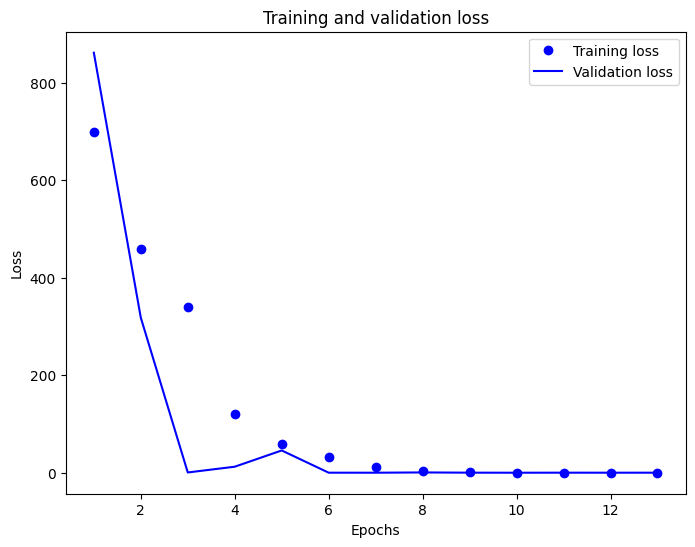

In [90]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

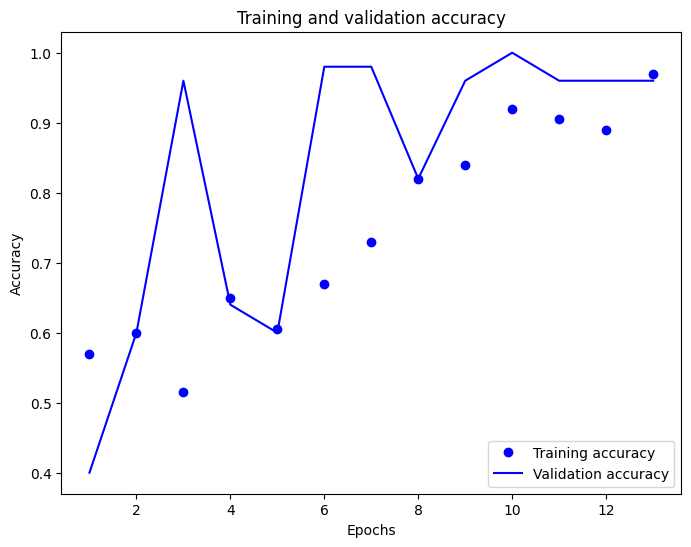

In [91]:
# Plot the accuracy curves for training and validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [96]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 108, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 221184)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    56,623,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169,871,813 (648.01 MB)

 Trainable params: 56,623,937 (216.00 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 113,247,876 (432.01 MB)

In [100]:
y_test.shape

(50,)

In [124]:
# Compute the final loss and accuracy
final_loss, final_acc = model.evaluate(X_test, y_test, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.000070, final accuracy: 1.000000


# NEW FILE & OUTPUT FILE:

In [77]:
predict_podcast = '../raw_data/full_podcast/world_out.mp3'
# Load the podcast file
podcast = AudioSegment.from_file(predict_podcast) # Load the new podcast file
podcast_duration = int(podcast.duration_seconds)
podcast_duration

python(88745) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88747) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


2107

In [ ]:
podcast_files_mp3_wav = [
  (os.path.join(full_audio_directory, "world_out.mp3"), [0,30, ((14*60)+16), ((14*60)+48), ((34*60)+36), ((35*60)+8)], "world_out"),
]

# Loop through each file and split into 5 sec chunks
for file_name, ad_list, podcast_name in podcast_files_mp3_wav:
    result = split_files(file_name, ad_list, podcast_name, episode_directory)
    print(f'Processing {podcast_name}: {result}')

Created folder: ../raw_data/5_sec_clips/99percentinvisible/world_out
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/world_out/1_0_2107_world_out.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/world_out/1_1_2107_world_out.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/world_out/1_2_2107_world_out.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/world_out/1_3_2107_world_out.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/world_out/1_4_2107_world_out.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/world_out/1_5_2107_world_out.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/world_out/1_6_2107_world_out.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/world_out/1_7_2107_world_out.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/world_out/1_8_2107_world_out.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/world_out/1_9_2107_world_out.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisi

In [ ]:
# directory = '../raw_data/5_sec_clips/99percentinvisible/world_out'

# for file in os.listdir(directory)[:10]:
#     sound_info, frame_rate = get_wav_info(os.path.join(directory,file))
#     pylab.specgram(sound_info, Fs=frame_rate)
#     pylab.savefig(f'../raw_data/5_sec_clips/99percentinvisible/planetmoney_images/{file}.png')
#     pylab.close()

In [65]:
directory = '../raw_data/5_sec_clips/99percentinvisible/world_out'
for item in os.listdir(directory):
    sound_info, frame_rate = get_wav_info(os.path.join(directory,item))
    pylab.specgram(sound_info, Fs=frame_rate)
    pylab.savefig(f'../raw_data/5_sec_clips/99percentinvisible/images/{item}.png')
    pylab.close()

/Users/jenni/.pyenv/versions/3.10.6/envs/podcast-ad-skipper/lib/python3.10/site-packages/matplotlib/axes/_axes.py:8089: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


In [99]:
predict_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../raw_data/5_sec_clips/99percentinvisible/images',
    batch_size=2107,
    labels=None,
    shuffle=True,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH)
    )
predict_ds

Found 2089 files.


<_PrefetchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

In [ ]:
list = ['../raw_data/5_sec_clips/99percentinvisible/test_set2/1_10_1848_infernal_machine.wav', '../raw_data/5_sec_clips/99percentinvisible/test_set2/1_11_1848_infernal_machine.wav']
specs = []
for file in list:
    specs.append(np.expand_dims(create_spectrogram(file), axis=-1))
specs

2

In [152]:
X_predict = np.expand_dims(create_spectrogram('../raw_data/5_sec_clips/99percentinvisible/spirit_halloween_test_set/0_60_2089_spirit_halloween.wav'), axis=-1)
X_predict.shape

(128, 216, 1)

In [153]:
processed_input = X_predict.reshape(1, 128, 216, 1)
processed_input.shape


(1, 128, 216, 1)

In [154]:
# rescale = tf.keras.Sequential([tf.keras.layers.Rescaling(1./256)])

# # Apply rescale to both datasets and augmentation only to training
# predict_ds = predict_ds.map(lambda x: (rescale(x)))

In [155]:
prediction = model.predict(processed_input) # Use the model to predict
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


array([[0.19113716]], dtype=float32)

In [84]:
prediction[1489]

array([0.01008256], dtype=float32)

In [ ]:
# List to hold the ad segments
ad_segments = []
clip_duration = 5

# Process the podcast in chunks of clip_duration seconds
for i in range(0, podcast_duration):
    start_time = i * 1000  # Convert to milliseconds
    end_time = (i + clip_duration) * 1000

    # Extract the clip from the podcast
    clip = podcast[start_time:end_time]

    # Save the clip as a temporary wav file (for librosa to process)
    clip_file = "temp_clip.wav"
    clip.export(clip_file, format="wav")

    #create spectrogram
    sound_info, frame_rate = get_wav_info(clip_file)
    pylab.specgram(sound_info, Fs=frame_rate)
    pylab.savefig(f'../raw_data/5_sec_clips/99percentinvisible/images_test_set2/temp.png')
    pylab.close()
    #add code to delete this later
    predict_ds = tf.keras.preprocessing.image_dataset_from_directory(
        '../raw_data/5_sec_clips/99percentinvisible/images_test_set2',
        batch_size=1,
        shuffle=True,
        color_mode='rgb',
        image_size=(IMAGE_HEIGHT, IMAGE_WIDTH)
        )

    prediction = model.predict(predict_ds) # Use the model to predict

    # If the model predicts 'ad' it will mark this segment as an ad (1)
    if prediction == 1:
        ad_segments.append((i, i + clip_duration))

    # Clean up the temporary file
    os.remove(clip_file)


Found 0 files belonging to 0 classes.


ValueError: No images found in directory ../raw_data/5_sec_clips/99percentinvisible/images_test_set2. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

In [78]:
def remove_ads_from_podcast(podcast_file, ad_segments):
    """
    Removes the ad segments from the podcast and returns an ad-free podcast.
    podcast_file: Path to the podcast audio file
    ad_segments: List of tuples with (start_time, end_time) of ads in seconds
    return: An AudioSegment object, the podcast without ads
    """
    podcast = AudioSegment.from_file(podcast_file) # Load the podcast file
    podcast_duration = len(podcast)

    clean_podcast = AudioSegment.empty() # Create an empty AudioSegment object
    current_time = 0

    for ad_start, ad_end in ad_segments:
        ad_start_ms = ad_start * 1000 # Convert to milliseconds
        ad_end_ms = ad_end * 1000

        clean_podcast += podcast[current_time:ad_start_ms] # Add the non-ad segment to the clean podcast
        current_time = ad_end_ms  # Update the current time

    clean_podcast += podcast[current_time:podcast_duration]  # Add the last segment of the podcast

    return clean_podcast

In [79]:
# Example of using the functions:
podcast_file = "../raw_data/full_podcast/spirithalloween.mp3" # Path to the new podcast file
ad_segments = detect_ads(podcast_file, model)  # Use trained model here
clean_podcast = remove_ads_from_podcast(podcast_file, ad_segments)

# Saving the ad-free podcast:
clean_podcast.export('podcast_without_ads3.mp3', format='mp3')

Error: file does not start with RIFF id

In [147]:
model.save('model.h5')